## Random Forest on Titanic Dataset

In [1]:
import pandas as pd
import numpy as np

import pylab
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [2]:
ls data

house_pricing/ titanic/


In [3]:
train_df = pd.read_csv('data/titanic/train.csv')
train_df.describe()  

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
test_df = pd.read_csv('data/titanic/test.csv')
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [5]:
test_df['Survived']= -1
titanic_df = pd.concat([train_df,test_df])

## Set missing values

In [6]:
# Show the median ticket price pre class and embarked
print(titanic_df.groupby(by=['Pclass', 'Embarked'])['Fare'].median())

# Missing values are for Fare = 80 and 1
print(titanic_df[titanic_df.Embarked.isnull()][['Pclass', 'Fare']])

# So, update Emnbarked to 'C'
titanic_df.at[titanic_df.Embarked.isnull(), 'Embarked'] = 'C'

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64
     Pclass  Fare
61        1  80.0
829       1  80.0


In [7]:
# Set cabin missing values to common value
titanic_df.at[titanic_df.Cabin.isnull(), 'Cabin'] = 'U0'

In [8]:
# Handle missing vslues of Age - select the average age in the training set
titanic_df.Age.fillna(titanic_df.Age.mean(),inplace=True)

In [9]:
#Fare - most common value - 8.05
titanic_df.at[titanic_df.Fare.isnull(), 'Fare'] = int(titanic_df.Fare.value_counts().head(1))

In [10]:
titanic_df.isnull().sum()

Age            0
Cabin          0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Survived       0
Ticket         0
dtype: int64

## Create new features

In [11]:
# Add deck feture as sub string of Cabin
import re
titanic_df['deck'] = titanic_df[~titanic_df.Cabin.isnull()].Cabin.apply( lambda x : re.compile("([a-zA-Z]+)").search(x).group())

In [12]:
# Add title as a  substgring of name
titanic_df['title'] = titanic_df.Name.apply(lambda x: re.compile(', (.*?)\.').findall(x)[0])
titanic_df.at[titanic_df.title=='Mme', 'title'] = 'Mrs'
titanic_df.at[titanic_df.title.isin(['Ms','Mlle']), 'title'] = 'Miss'
titanic_df.at[titanic_df.title.isin(['Don', 'Jonkheer']), 'title'] = 'Sir'
titanic_df.at[titanic_df.title.isin(['Dona', 'Lady', 'the Countess']), 'title'] = 'Lady'
titanic_df.at[titanic_df.title.isin(['Capt', 'Col', 'Major', 'Dr', 'Officer', 'Rev']), 'title'] = 'Officer'
titanic_df.title.value_counts()

Mr         757
Miss       264
Mrs        198
Master      61
Officer     23
Lady         3
Sir          3
Name: title, dtype: int64

## We'll seperate categorical and numerical features

In [13]:
# Drop not-usable columns
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [14]:
numerical_features = titanic_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features

['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Survived']

In [15]:
categorical_features = titanic_df.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_features

['Embarked', 'Sex', 'deck', 'title']

### Let's label and one-hot-encode necessary features

In [16]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

def label_encoding(df, d_lbl=None):
    # if a label-dictionary is not supplied, we assume we should train/fit it
    if not d_lbl:
        d_lbl = defaultdict(LabelEncoder)

        for col in categorical_features:
            d_lbl[col].fit(df[col])
    
    for col in categorical_features:
        df[col] = d_lbl[col].transform(df[col])
    
    return d_lbl, df
    
fitted_label_dict, titanic_df = label_encoding(titanic_df)
titanic_df.head(10)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,deck,title
0,22.000000,2,7.2500,0,3,1,1,0,8,3
1,38.000000,0,71.2833,0,1,0,1,1,2,4
2,26.000000,2,7.9250,0,3,0,0,1,8,2
3,35.000000,2,53.1000,0,1,0,1,1,2,4
4,35.000000,2,8.0500,0,3,1,0,0,8,3
5,29.881138,1,8.4583,0,3,1,0,0,8,3
6,54.000000,2,51.8625,0,1,1,0,0,4,3
7,2.000000,2,21.0750,1,3,1,3,0,8,1
8,27.000000,2,11.1333,2,3,0,0,1,8,4
9,14.000000,0,30.0708,0,2,0,1,1,8,4


In [17]:
train_df = titanic_df[titanic_df.Survived != -1]
test_df = titanic_df[titanic_df.Survived == -1]

## Lets see how Random Forest actually works
### We can build random forest from multiple decision trees

In [19]:
train_df.sample(sample_size).head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,deck,title
357,38.000000,2,13.0000,0,2,0,0,0,8,2
754,48.000000,2,65.0000,2,2,0,1,1,8,4
478,22.000000,2,7.5208,0,3,1,0,0,8,3
680,29.881138,1,8.1375,0,3,0,0,0,8,2
170,61.000000,2,33.5000,0,1,1,0,0,1,3


In [20]:
train_df.sample(sample_size).head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,deck,title
209,40.0,0,31.0000,0,1,1,0,1,0,3
583,36.0,0,40.1250,0,1,1,0,0,0,3
608,22.0,0,41.5792,2,2,0,1,1,8,4
638,41.0,2,39.6875,5,3,0,0,0,8,4
193,3.0,2,26.0000,1,2,1,1,1,5,1


In [26]:
from sklearn.tree import DecisionTreeClassifier

# grow each tree deep - no max depth
tree_classifier = DecisionTreeClassifier(max_depth=None, random_state=123)

# list for storing predicted Survived passenger from each tree
predictions = []
tree_count = 11

# grow one tree for each bootstrap sample and make predictions on the testing data
for sample in range(1,tree_count):
    sample_size = int(train_df.shape[0]*0.66)
    sample_data = train_df.sample(sample_size)
    X_train_sample = sample_data#.drop('Survived',axis=0)
    y_train_sample = sample_data['Survived']
    tree_classifier.fit(X_train_sample, y_train_sample)
    y_pred = tree_classifier.predict(test_df)
    predictions.append(y_pred)
    print('sample number:', sample, 'results: ')
    print(y_pred[:30])


# convert predictions from list to NumPy array
predictions = np.array(predictions)

# Majority vote from all classifiers
sum_array = np.sum(predictions, axis=0)
print(sum_array[:20])
[1 if x > 5 else 0 for x in sum_array][0:20]

('sample number:', 1, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 2, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 3, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 4, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 5, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 6, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 7, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 8, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 9, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('sample number:', 10, 'results: ')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Split the train data to train and validation (the test data has no expected prediction)

In [27]:
y_col_name = 'Survived'
X = train_df.drop([y_col_name], axis=1)
y = train_df[y_col_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
## Run the random forest model

In [29]:
from sklearn.ensemble import RandomForestClassifier
rand_classifier = RandomForestClassifier()
print('Lets see how the model looks:')
print(rand_classifier)

Lets see how the model looks:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Random state effect - the seed used by the random number generator
* Learning an optimal decision tree is known to be NP-complete
* Practical decision-tree learning algorithms based on heuristic algorithms such as "greedy algorith"
* Locally optimal decisions are made at each node
* Such algorithms cannot guarantee to return the globally optimal decision tree. 
* Training multiple trees in an ensemble learner

### So, lets run the model 5 times and we can see different scores in each iteration

In [30]:
from sklearn.metrics import accuracy_score

for i in range(1,6):
    rand_classifier = RandomForestClassifier(criterion='entropy', oob_score=True, n_estimators=50)
    clf_rfc1 = rand_classifier.fit(X_train, y_train)
    print('Iteration', i, 'out of bag score:', clf_rfc1.oob_score_ ,'and accuracy score:', accuracy_score(y_test, clf_rfc1.predict(X_test)))
    

('Iteration', 1, 'out of bag score:', 0.80201342281879195, 'and accuracy score:', 0.79661016949152541)
('Iteration', 2, 'out of bag score:', 0.80704697986577179, 'and accuracy score:', 0.8067796610169492)
('Iteration', 3, 'out of bag score:', 0.80704697986577179, 'and accuracy score:', 0.81016949152542372)
('Iteration', 4, 'out of bag score:', 0.81543624161073824, 'and accuracy score:', 0.81355932203389836)
('Iteration', 5, 'out of bag score:', 0.82046979865771807, 'and accuracy score:', 0.81694915254237288)


## Tuning the max_depth feature using Cross Validation

In [31]:
# list of values to try for max_depth
max_depth_range = range(1, 20)

# list to store the average F1 for each value of max_depth
scores = []

# Run 10-fold cross-validation for each value of max_depth
from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    tree_classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=depth)
    score = cross_val_score(tree_classifier, X, y, cv=10, scoring='f1')
    scores.append(np.mean(score)) 
    

/Users/dgoldenberg/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('max score:', 0.74893782182977109, 'with index:', 10)


Text(0,0.5,u'score')

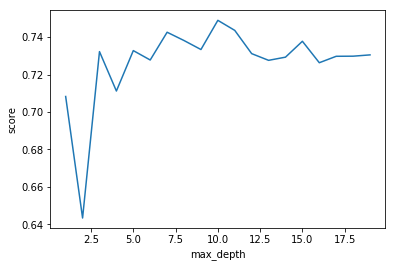

In [32]:
print('max score:', max(scores), 'with index:', max_depth_range[np.argmax(scores)])
plt.plot(max_depth_range, scores)
plt.xlabel('max_depth')
plt.ylabel('score')

### Tuning number of estimators parameter

* Important tuning parameter is **n_estimators**, which is the number of trees that should be grown. 

In [33]:
from tqdm import tqdm_notebook as tqdn

In [34]:
%%time
# list of values to try for n_estimators
estimator_range = range(10, 410, 10)

# list to store the average RMSE for each value of n_estimators
scores = []

# use 5-fold cross-validation with each value of number of estimator (WARNING: SLOW!)
for estimator in tqdn(estimator_range):
    tree_classifier = RandomForestClassifier(n_estimators=estimator, random_state=1, max_depth=10, n_jobs = -1)
    curr_score = cross_val_score(tree_classifier, X, y, cv=5, scoring='f1')
    scores.append(np.mean(curr_score))

A Jupyter Widget


CPU times: user 2min 35s, sys: 21.5 s, total: 2min 56s
Wall time: 2min 58s


('max score:', 0.77737154896734251, 'with index:', 190)


Text(0,0.5,u'Score')

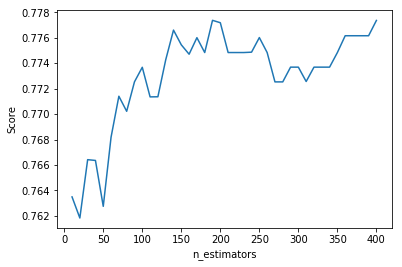

In [35]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
print('max score:', max(scores), 'with index:', estimator_range[np.argmax(scores)])
plt.plot(estimator_range, scores)
plt.xlabel('n_estimators')
plt.ylabel('Score')

### Tuning the max_features to use parameter
Another important tuning parameter is **max_fetures**, which is the max number of fetures each tree used. 

In [45]:
# list of values to try for max_features
feature_range = range(1, len(X.columns)+1)
scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in tqdn(feature_range):
    tree_classifier = RandomForestClassifier(n_estimators=310, max_features=feature, random_state=1, max_depth=10, n_jobs=-1)
    curr_score = cross_val_score(tree_classifier, X, y, cv=10, scoring='f1')
    scores.append(np.mean(curr_score))

A Jupyter Widget

('max score:', 0.77582420775608063, 'with index:', 6)


Text(0,0.5,u'Score')

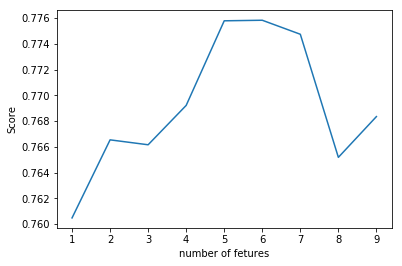

In [46]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
print('max score:', max(scores), 'with index:', feature_range[np.argmax(scores)])
plt.plot(feature_range, scores)
plt.xlabel('number of fetures')
plt.ylabel('Score')

## Feature importance
* There is now way to get an average tree. 
* Quantify how much each feature is used in the forest by averaging their score in each tree.

In [47]:
tree_classifier = RandomForestClassifier(n_estimators=310, max_features=6, random_state=1, max_depth=10)
tree_classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=310, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [48]:
# compute feature importances
pd.DataFrame({'feature':X.columns, 'importance':tree_classifier.feature_importances_}).sort_values('importance')

,feature,importance
3,Parch,0.021777
1,Embarked,0.026156
6,SibSp,0.053579
7,deck,0.063177
8,title,0.082622
4,Pclass,0.094049
0,Age,0.174776
2,Fare,0.184564
5,Sex,0.299300


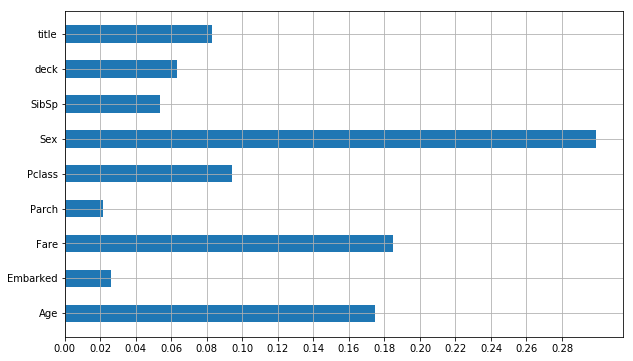

In [49]:
plt.figure(figsize=(10,6))
plt.barh(np.arange(X.columns.shape[0]), tree_classifier.feature_importances_, 0.5)
plt.yticks(np.arange(X.columns.shape[0]), X_train.columns)
plt.grid()
plt.xticks(np.arange(0,0.3,0.02));